In [1]:
import tensorflow as tf

In [2]:
for gpu in tf.config.experimental.list_physical_devices("GPU"):
    tf.compat.v2.config.experimental.set_memory_growth(gpu, True)

In [3]:
import logging
logging.getLogger("tensorflow").disabled = True

In [4]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [5]:
model = VGG16(weights="imagenet")
img_path = "/home/rtx/jobin/chollet_keras/data/elephants.png"

In [6]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [7]:
img = load_img(img_path,target_size=(224,224))
x = img_to_array(img)
x = np.expand_dims(x,axis=0)
x = preprocess_input(x)

In [8]:
preds = model.predict(x)

In [9]:
decode_predictions(preds,top=3)

[[('n02504458', 'African_elephant', 0.87656206),
  ('n01871265', 'tusker', 0.11420009),
  ('n02504013', 'Indian_elephant', 0.009071711)]]

In [10]:
np.argmax(preds[0])

386

In [11]:
activation_model = Model(model.input,[model.output,model.get_layer("block5_conv3").output])

In [12]:
_, last_conv_layer_np = activation_model.predict(x)

with tf.GradientTape() as tape:
    tape.watch(tf.convert_to_tensor(x))
    preds,layer_out = activation_model(x)
    african_elephant_output = preds[0][386]

grads = tape.gradient(african_elephant_output,layer_out)
pooled_grads = tf.reduce_mean(grads,axis=(0,1,2))

for i in range(512):
    last_conv_layer_np[0][:,:,i] *= pooled_grads[i]

In [16]:
last_conv_layer_np.shape

(1, 14, 14, 512)

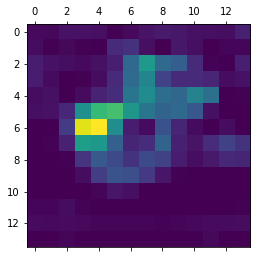

In [13]:
heatmap = np.mean(last_conv_layer_np,axis=-1)
heatmap = np.maximum(heatmap,0)
heatmap /= np.max(heatmap)
heatmap = heatmap[0]
plt.matshow(heatmap)

In [18]:
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap,(img.shape[1],img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap,cv2.COLORMAP_JET)
superimposed_image = heatmap * 0.6 + img
cv2.imwrite("elephant_cam.jpg",superimposed_image)

True